## 1. Introduction

The National Basketball Association (NBA), comprised of thirty professional basketball teams in the United States and Canada, is one of the most influential athletic leagues in North America. As of 2018, the NBA is the fifth largest sports league in the world with a total revenue of about \$8 billion. Some of this tremendous value is distributed to NBA players in the form of
inordinately large salaries. Most teams have annual payrolls of over \$100 million, so it is crucial for teams to ensure that players are worth the price of their contracts.  

We expect salaries to be driven by two main factors: on-court performance and "social power." We expect that players who help their teams win more games and contend for championship titles should be paid well. Therefore, on-court performance data should be able to capture a large portion of the variation in player salaries.The second factor, "social power," is a player’s ability to increase team revenues in the form of increased ticket and merchandise sales. We hypothesize that players with large social media followings and wide cultural influence will earn larger salaries regardless of their team’s performance.

In [7]:
#Load required packages
library(alr4)
library(tidyverse)
library(olsrr)

## 2. Data and Approach

The data used in this analysis comes from the "Social Power NBA" dataset posted on the Kaggle website.
The data includes on-court performance statistics from a sample of 100 NBA players
during the 2016-2017 NBA season, as well as Twitter engagement metrics for each player.

In [15]:
#Read the data file into nba_data
nba_data <- read.csv("NBA Data.csv")
head(nba_data)

,player,team,pos,age,salary,netrtg,astpct,rebpct,ts,usg,...,vorp,ortg,drtg,orebpct,drebpct,efg,pts,twitter,bpm,ws
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,Russell Westbrook,OKC,PG,28,26.54,3.3,0.543,0.167,0.554,0.408,...,9.3,107.9,104.6,0.053,0.279,0.476,31.6,1,11.1,13.1
2,Boban Marjanovic,DET,C,28,7.00,1.9,0.054,0.239,0.606,0.248,...,0.6,104.3,102.4,0.166,0.313,0.545,5.5,0,5.5,1.7
3,Demetrius Jackson,BOS,PG,22,1.45,6.3,0.300,0.103,0.753,0.172,...,0.1,124.2,117.8,0.091,0.118,0.875,2.0,1,9.8,0.1
4,Anthony Davis,NOP,C,24,22.12,1.7,0.110,0.170,0.580,0.326,...,5.4,104.2,102.5,0.067,0.269,0.518,28.0,1,5.9,11.0
5,James Harden,HOU,PG,27,26.50,6.3,0.505,0.123,0.613,0.341,...,8.0,113.6,107.3,0.035,0.212,0.525,29.1,1,8.7,15.0
6,Kevin Durant,GSW,PF,28,26.54,16.0,0.218,0.137,0.651,0.276,...,5.7,117.2,101.3,0.023,0.232,0.594,25.1,1,8.9,12.0


Looking at the scatterplot matrix below, we can see several variables that will need transformation. The points in the 
followers and free throw attempt rate (ftar) plots are clustered on the left-hand side of their respective plots. 
We may need to transform these variables to achieve a linear mean function.

Some players also have zero Twitter followers, and the turnover rate (tov) for some players is zero. 
We will add 0.01 to Twitter followers and 0.001 to turnover rate for each player to ensure the values are strictly positive. 
This allows us to power transform these variables later if necessary.

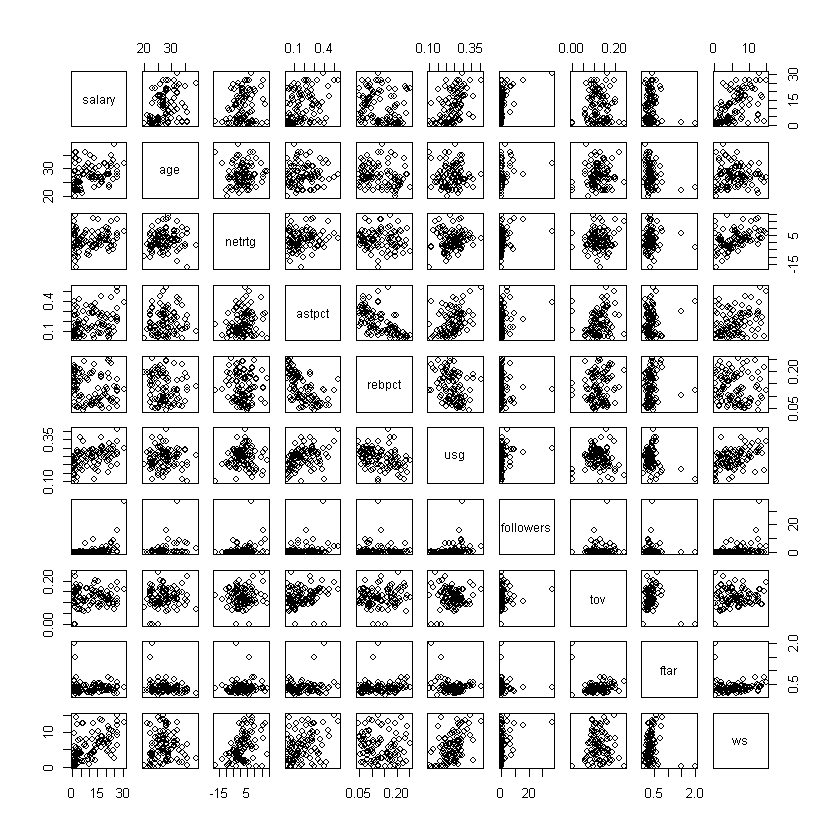

In [16]:
#View scatterplot of the data
pairs(~ salary + age + netrtg + astpct + rebpct +
        usg + followers + tov + ftar + ws, data = nba_data)

#Add 0.01 to followers and 0.001 to tov
nba_data$followers <- nba_data$followers+0.01
nba_data$tov <- nba_data$tov+0.001

We used the multivariate Box-Cox method to simulataneously select the optimal transformations for each predictor. 
Rather than using the estimated powers from the Box-Cox transformation, we used the closest “standard” power transformation 
values. We ran the likelihood ratio tests with the null hypotheses of no transformations and log transformations of all 
predictors, both of which were rejected.

We proceed with a log transformation of age, assist percentage, and Twitter followers, a square
root transformation of win share, and an inverse square root transformation of free throw attempt
rate.

In [17]:
#Multivariate Box-Cox transformation of predictors
summary(trp <- powerTransform(cbind(age,astpct,rebpct,followers,usg,ftar,ws,tov)~1, data=nba_data))

bcPower Transformations to Multinormality 
          Est Power Rounded Pwr Wald Lwr Bnd Wald Upr Bnd
age         -0.3936         0.0      -1.6901       0.9029
astpct       0.2108         0.0      -0.0326       0.4542
rebpct       0.6821         1.0       0.2267       1.1375
followers   -0.0414         0.0      -0.1295       0.0468
usg          0.9533         1.0       0.3766       1.5299
ftar        -0.3125        -0.5      -0.6113      -0.0136
ws           0.5679         0.5       0.3762       0.7596
tov          1.1774         1.0       0.9044       1.4504

Likelihood ratio test that transformation parameters are equal to 0
 (all log transformations)
                                         LRT df       pval
LR test, lambda = (0 0 0 0 0 0 0 0) 212.9403  8 < 2.22e-16

Likelihood ratio test that no transformations are needed
                                         LRT df       pval
LR test, lambda = (1 1 1 1 1 1 1 1) 612.8836  8 < 2.22e-16

To select the predictors for our initial regression model, we used backward stepwise variable selection with AIC as the 
information criterion. This selection method begins with a model containing all the potential predictors, then removes the 
variable with the least explanatory power according to the information criterion. This process is repeated, removing one 
variable at a time, until the criterion no longer improves.

In [ ]:
#Model with all transformed predictors
init_model_1 <- lm(salary~pos+log(age)+netrtg+log(astpct)+rebpct+
                   usg+log(followers)+tov+I(ftar^(-1/2))+I(ws^(1/2)), data=nba_data)

#MODEL 1: Stepwise regression with transformed predictors and untransformed response
step(init_model_1, scope=~1, direction="backward")

## 3. Initial Model
The backward selection algorithm specified the model shown below. The model has an R-squared value of 0.5347. The two most 
significant predictors in the model are win share and Twitter followers, which provides evidence for our initial theory that 
player salary is influenced by both on-court performance and social influence.

In [20]:
summary(m1 <- lm(salary ~ log(age) + usg + log(followers) + tov + 
                    I(ws^(1/2)), data = nba_data))


Call:
lm(formula = salary ~ log(age) + usg + log(followers) + tov + 
    I(ws^(1/2)), data = nba_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.5215  -3.8866   0.4428   3.6290  13.7934 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -39.5224    16.0928  -2.456 0.015890 *  
log(age)        12.7195     4.5696   2.783 0.006502 ** 
usg             27.6944    12.3471   2.243 0.027247 *  
log(followers)   1.6188     0.4066   3.982 0.000135 ***
tov            -20.5291    14.6878  -1.398 0.165493    
I(ws^(1/2))      3.0615     0.8650   3.539 0.000626 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.995 on 94 degrees of freedom
Multiple R-squared:  0.5582,	Adjusted R-squared:  0.5347 
F-statistic: 23.76 on 5 and 94 DF,  p-value: 2.274e-15


We used a normal Q-Q plot and residual histogram to ensure the residuals are normally distributed with a constant variance. 
The residuals fall approximately on the normal line in the Q-Q plot, with some slight skew at the tail ends of the plot.

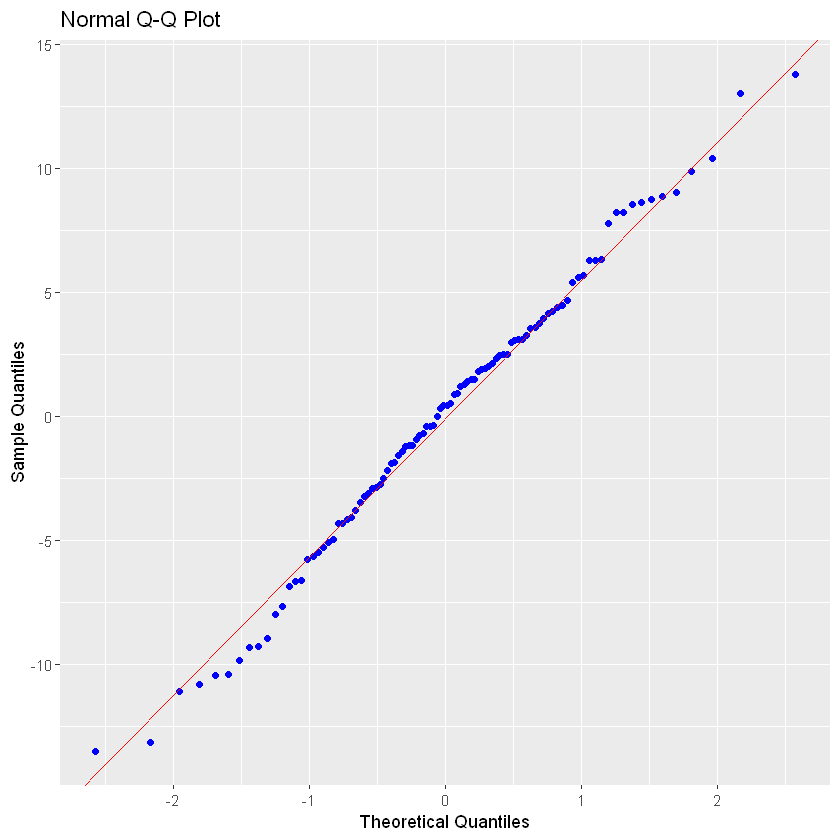

In [21]:
#Normal qqplot of residuals
ols_plot_resid_qq(m1)

The residual histogram is slightly right-skewed but approximates a normal distribution. These two plots do not reveal any 
obvious violations of our normality assumptions.

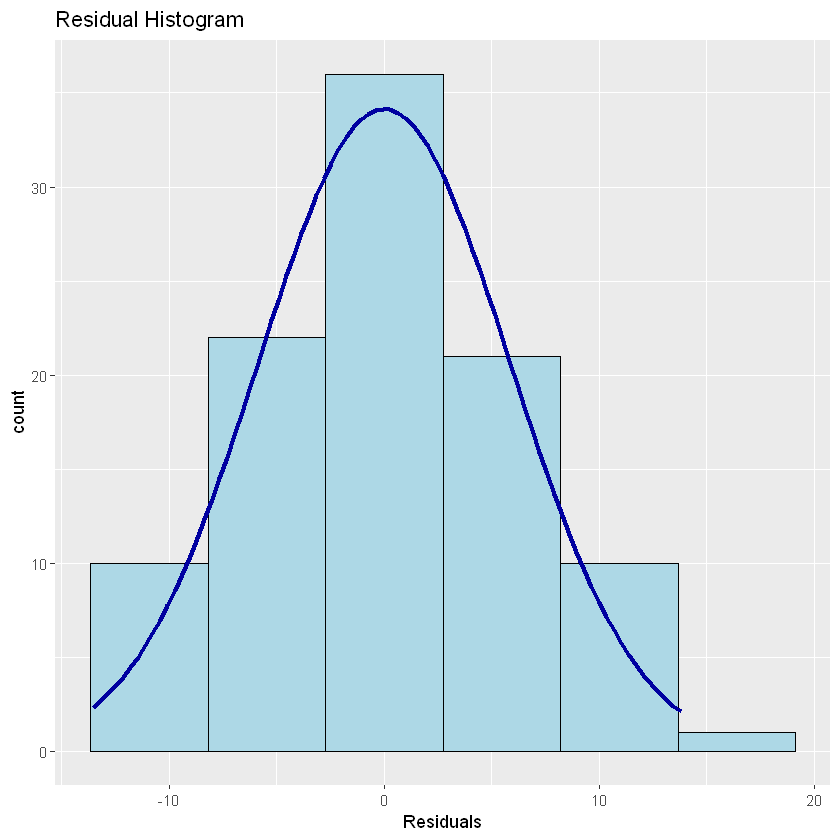

In [22]:
#Residual histogram
ols_plot_resid_hist(m1)

The residual vs. fitted value plot below raises some potential concerns. We suspect there
may be a non-constant variance issue, as the variance appears to be smaller at the tail ends of the
plot than in the middle. Thus, we consider the possibility of transforming the response variable to
achieve a constant variance.

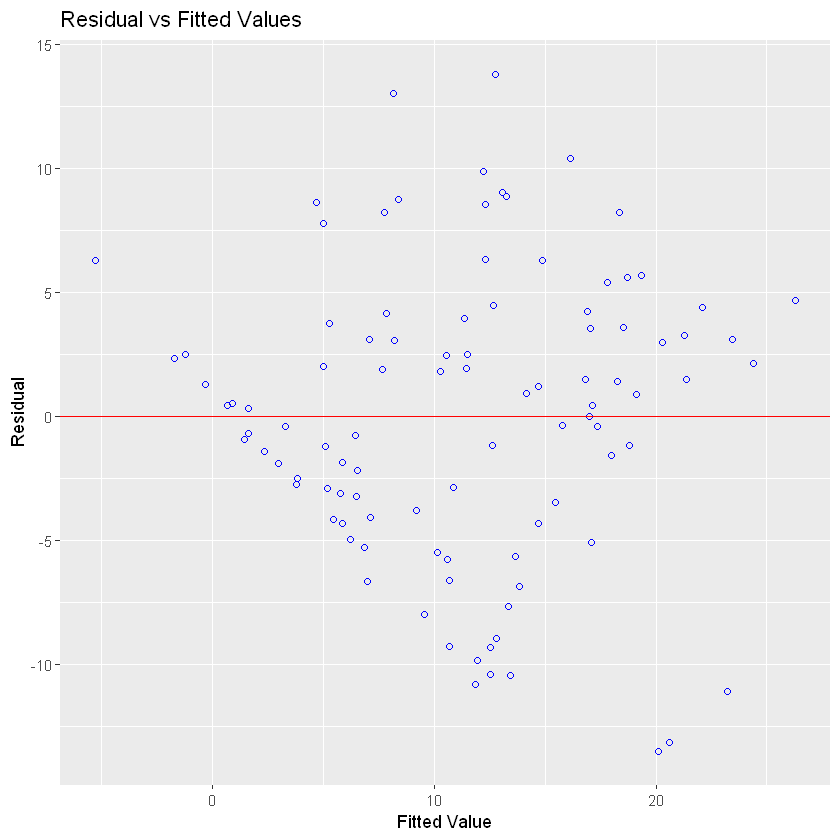

In [23]:
#Plot residual vs. fitted values
ols_plot_resid_fit(m1)

## 4. Response Transformation
Next, we use an inverse response plot and a Box-Cox transformation plot to explore potential transformations of our response 
variable (salary). The plots will show us the optimal power transformation of the response. 

lambda,RSS
<dbl>,<dbl>
0.4401476,1815.258
-1.0000000,2904.169
0.0000000,1894.815
1.0000000,1886.070


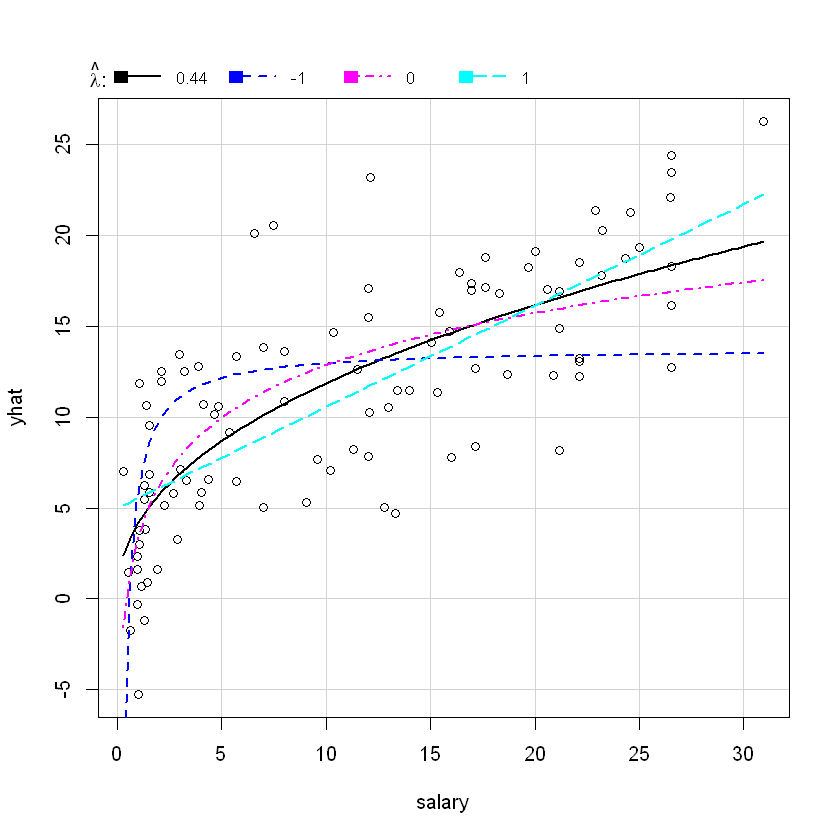

bcPower Transformation to Normality 
   Est Power Rounded Pwr Wald Lwr Bnd Wald Upr Bnd
Y1    0.3733         0.5       0.1839       0.5627

Likelihood ratio test that transformation parameter is equal to 0
 (log transformation)
                           LRT df       pval
LR test, lambda = (0) 16.53652  1 4.7722e-05

Likelihood ratio test that no transformation is needed
                           LRT df       pval
LR test, lambda = (1) 34.93397  1 3.4108e-09

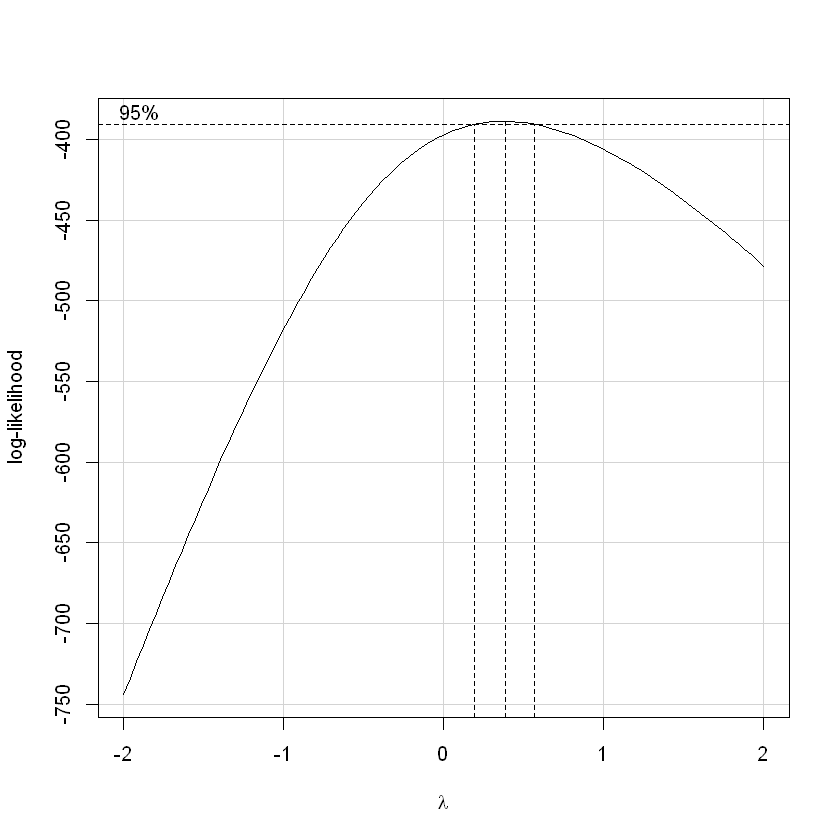

In [24]:
#Inverse response plot
inverseResponsePlot(m1)

#Box-Cox transformation plot
boxCox(m1)
summary(powerTransform(m1))

After inspecting these plots, a square root transformation of salary seems to be best to minimize RSS while also stabilizing variance. Using the square root transformation will also ensure all salary values remain strictly positive.

## 5. Final Model
Next, we fit a regression model of our transformed salary value on all of the initial predictor values. We again used backward selection to automatically select the best predictors for the model.

In [25]:
#Model with transformed predictors and Salary^(1/2)
init_model_2 <- lm(I(salary^(1/2))~pos+log(age)+netrtg+log(astpct)+rebpct+
                     usg+log(followers)+tov+I(ftar^(-1/2))+I(ws^(1/2)), data=nba_data)

In [ ]:
#Backward selection algorithm for new model
step(init_model_2, scope=~1, direction="backward")

The backward selection algorithm specified the final model shown below. The adjusted R-squared value is 0.5593, which represents about a 2.5% improvement over the initial model. The coefficients on age, usage rate, followers, and win share are statistically significant and all predictors have their expected signs.

In [27]:
#MODEL 2: Model with transformed predictors and response
m2 <- lm(I(salary^(1/2)) ~ log(age) + netrtg + usg + log(followers) + 
        tov + I(ws^(1/2)), data = nba_data)
summary(m2)


Call:
lm(formula = I(salary^(1/2)) ~ log(age) + netrtg + usg + log(followers) + 
    tov + I(ws^(1/2)), data = nba_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2005 -0.5952  0.1503  0.5913  1.8710 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -6.62346    2.59246  -2.555 0.012246 *  
log(age)        2.41215    0.73639   3.276 0.001482 ** 
netrtg         -0.02423    0.01628  -1.488 0.140028    
usg             4.29390    2.00509   2.141 0.034848 *  
log(followers)  0.24501    0.06560   3.735 0.000323 ***
tov            -3.28019    2.36329  -1.388 0.168461    
I(ws^(1/2))     0.63948    0.14650   4.365 3.29e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9644 on 93 degrees of freedom
Multiple R-squared:  0.586,	Adjusted R-squared:  0.5593 
F-statistic: 21.94 on 6 and 93 DF,  p-value: 6.326e-16


Looking at the residual histogram below, there are no major violations of our normality assumptions. However, there are some potential outliers on the left-hand side of the plot.

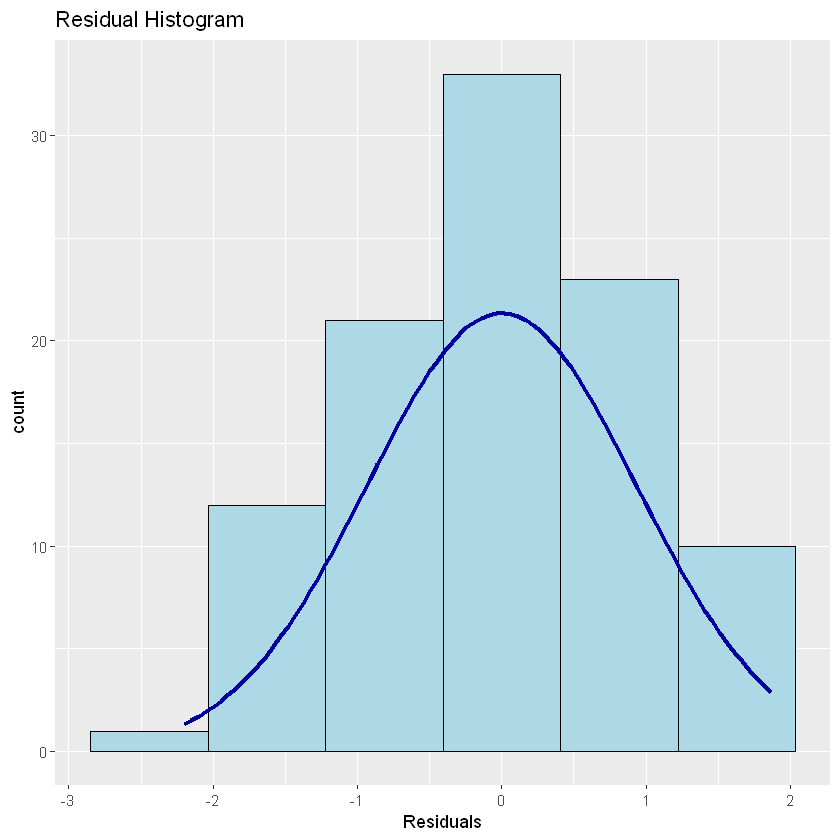

In [28]:
#Residual histogram
ols_plot_resid_hist(m2)

The residual vs. fitted values plot below does appear to have more constant variance than the initial model, but we are still concerned about the possibility of outliers.

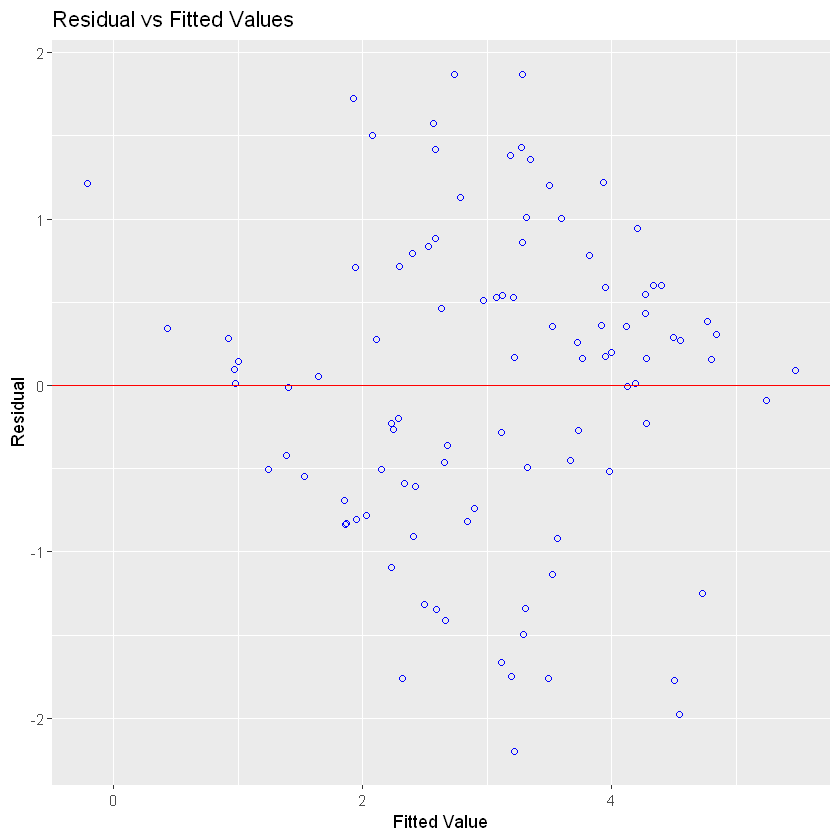

In [29]:
#Plot residual vs. fitted values
ols_plot_resid_fit(m2)

## 6. Outlier Analysis
We use a Cook's distance bar plot to identify potential outliers.

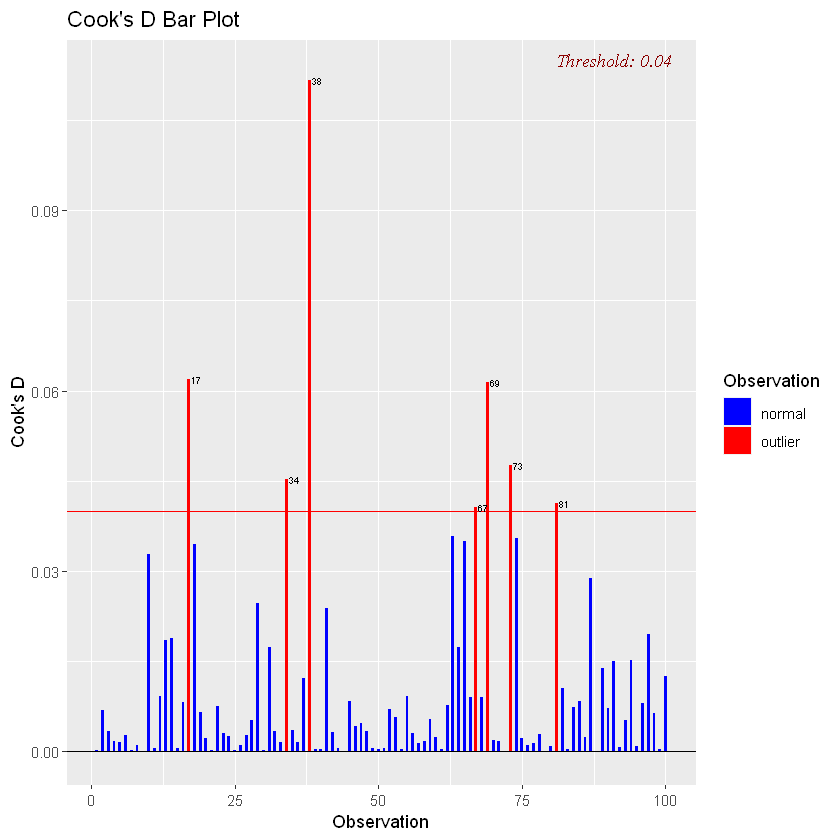

In [30]:
#Cook's distance plot
ols_plot_cooksd_bar(m2)

The biggest outliers appear to be observations 17, 38, and 69. As shown below, these correspond to Rudy Gobert, Edy Tavares, and Brook Lopez, respectively.

In [31]:
#Read the data file into nba_data_1 (untransformed data)
nba_data_1 <- read.csv("NBA Data.csv")

#Add predicted salary from final model to nba_data_1
nba_data_1$fitted_salary <- (fitted(m2))^2

#Identify and print outliers
outliers <- c(17, 38, 69)
variables <- c("player", "age", "usg", "followers", "ws", "salary", "fitted_salary")
print(nba_data_1[outliers, variables])

        player age   usg followers   ws salary fitted_salary
17 Rudy Gobert  25 0.167     0.195 14.3   2.10  10.21681....
38 Edy Tavares  25 0.137     0.008  0.1   1.00  0.044832....
69 Brook Lopez  29 0.290     0.000  4.9  21.16  7.469315....


These outliers give us an indication of the types of observations the regression model is unlikely to predict accurately.

Rudy Gobert was in the final year of his 4-year rookie contract with the Utah Jazz during the 2016-2017 season. Gobert was fairly young at 25, and had a high win share value of 14.3. This led the regression model to predict a salary of \\$10.22M, while he earned only \\$2.1M in the 2016-2017 season. After the season, Gobert signed a 4-year contract with the Utah Jazz for \\$25.5M per year. Gobert represents overperforming young players still in their rookie contracts.

Edy Tavares played a single NBA game in 2016-2017 for the Cleveland Cavaliers, and had a below average win share, usage rate, and number of Twitter followers. The model predicts a salary of \$40,000, while his actual salary was \\$1M. Tavares entered the league in 2015-2016, giving him one year of experience entering the season. The league minimum salary in 2016-2017 for players with one year of experience was \\$874,636, meaning the Cavaliers were forced to pay Tavares much more than his performance warranted. Tavares is a case of an underperforming player benefitting from a high league minimum salary.

Brook Lopez was 29 years old during the 2016-2017 season with a high usage rate of 29% and an average win share value of 4.9. However, Lopez did not have a Twitter account during the season, so the model was unable to accurately predict his salary. The model predicted a salary of about \\$7.5M, compared to his actual salary of \$21.6M. Lopez represents productive players without a Twitter account or wide social media influence.

## 7. Conclusion
We see that both game performance and social media following impact NBA player compensation. The model performs well, but the outlier analysis demonstrates some of the potential issues that could be worked out in the future. Specifically, we might consider including a dummy variable to indicate whether a player has a Twitter account, as well as taking the league minimum salary into consideration. 

An unfortunate consequence of our model is that transforming the response variable makes it difficult to interpret the magnitude of the coefficient estimates. A future model may attempt to leave the response untransformed to give us more information about the effects of the predictors on the response.